# Preprocessing and data set creation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from TNGDataSet.TNGDataSet import loadTNGDataset
plt.style.use(astropy_mpl_style)
import jax
import jax.numpy as jnp
import transformations.transformations as _transformations
from itertools import cycle

Make sure that there is at least one GPU

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# scaling function
from transformations import transformations as _transformations
def ScaleImage(img, z = 0.1, experiment = 'HSC', new_size = 150):
    return _transformations.ScaleImage(img,experiment=experiment,new_size=new_size,z=z)

## Tracing function
set to 0 for no traces up to 4 for alot of traces

In [4]:
os.environ["DIFF_TRACE"]="0"

## Set up dataset creation arguments and load the data set

Dataset is only loaded the first time and will be stored locally in data_dir/tng_data_set folder
If you wish to reload you need to delete this folder and relanch this cell

In [5]:
subsets = [tfds.Split.TRAIN,tfds.Split.VALIDATION, tfds.Split.TEST]
all_dataset = loadTNGDataset(
    input_dir='/gpfsscratch/rech/owt/commun/diffusion/', 
    output_dir='/gpfsdswork/projects/rech/owt/uow47az/tng_data_set',
    train_percent=0.000001, 
    val_percent=0.000001, 
    test_percent=0.000001,
    Scaler_fcn=ScaleImage ,
    generation_verbosity=1000,
    Image_Size=(150,150),
    band_filters=['CFHT_MEGACAM.U', 'SUBARU_HSC.G' ,'SUBARU_HSC.R' ,'CFHT_MEGACAM.R' ,'SUBARU_HSC.I', 'SUBARU_HSC.Z' ,'SUBARU_HSC.Y'],
    subsets = subsets
)

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]2023-07-06 15:56:21.488925: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Dataset tng_data_set downloaded and prepared to /home/wassim/Projects/Hackathon23/tng_data_set/tng_data_set/1.0.0. Subsequent calls will reuse this data.


In [6]:
train_dataset = all_dataset[0]
validation_dataset = None
test_dataset= None
if len(subsets) > 1:
    validation_dataset = all_dataset[1]
if len(subsets) > 2 :
    test_dataset =  all_dataset[2]

<_PrefetchDataset element_spec={'BUNIT': TensorSpec(shape=(), dtype=tf.string, name=None), 'CAMERA': TensorSpec(shape=(), dtype=tf.string, name=None), 'EXTNAME': TensorSpec(shape=(), dtype=tf.string, name=None), 'FILTER': TensorSpec(shape=(), dtype=tf.string, name=None), 'FOVSIZE': TensorSpec(shape=(), dtype=tf.float32, name=None), 'NAXIS1': TensorSpec(shape=(), dtype=tf.int32, name=None), 'NAXIS2': TensorSpec(shape=(), dtype=tf.int32, name=None), 'ORIGIN': TensorSpec(shape=(), dtype=tf.string, name=None), 'REDSHIFT': TensorSpec(shape=(), dtype=tf.float32, name=None), 'SIMTAG': TensorSpec(shape=(), dtype=tf.string, name=None), 'SNAPNUM': TensorSpec(shape=(), dtype=tf.int32, name=None), 'SUBHALO': TensorSpec(shape=(), dtype=tf.int32, name=None), 'img': TensorSpec(shape=(150, 150), dtype=tf.float32, name=None)}>

In [7]:
# add noise data and get iterator
def load_dataset(batch_size, noise_dist_std,ds):

  def pre_process(im):
    """ Pre-processing function preparing data for denoising task
    """
    # Cutout a portion of the map
    x = tf.image.resize_with_crop_or_pad(im['img'][..., tf.newaxis], 128, 128)
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    # Sample random Gaussian noise
    u = tf.random.normal(tf.shape(x))
    # Sample standard deviation of noise corruption
    s = noise_dist_std * tf.random.normal((1, 1, 1))
    # Create noisy image
    y = x + s * u
    return {'x':x, 'y':y, 'u':u,'s':s}

  ds = ds.shuffle(buffer_size=10*batch_size)
  ds = ds.repeat()
  ds = ds.map(pre_process)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds.as_numpy_iterator()

In [16]:
noise_factor = .25
cosmos_train_dset = load_dataset(32, noise_factor,train_dataset)
cosmos_val_dset = load_dataset(32, noise_factor,validation_dataset)
cosmos_test_dset = load_dataset(32, noise_factor,test_dataset)

2023-07-06 16:04:05.918661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-07-06 16:04:05.919855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


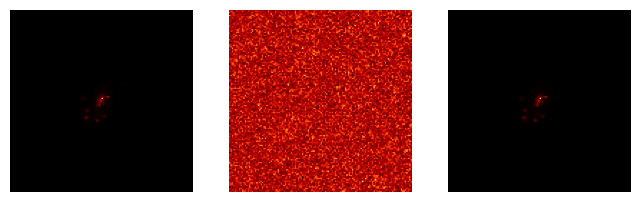

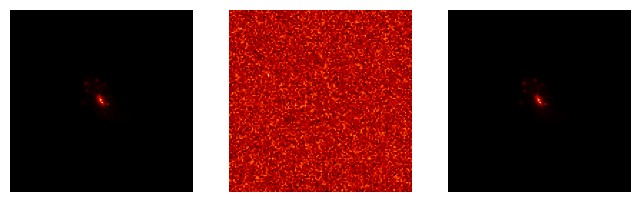

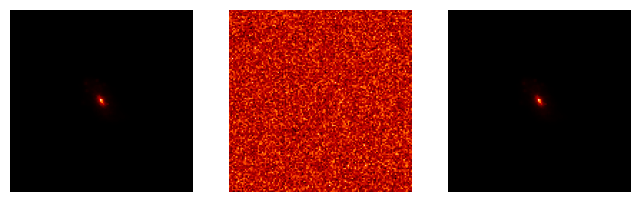

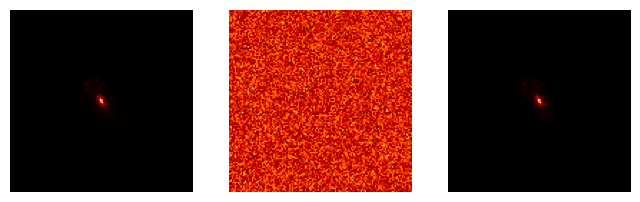

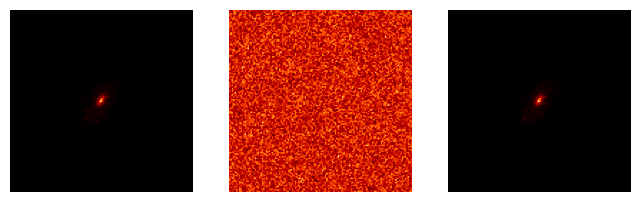

In [9]:
%matplotlib inline

batch = next(cosmos_train_dset)

for i in range(5):
    figure()
    subplot(131)
    imshow(batch['x'][i])
    axis('off')
    subplot(132)
    imshow(batch['u'][i])
    axis('off')
    subplot(133)
    imshow(batch['y'][i])
    axis('off')


In [10]:
np.shape(batch['y'][i])

(128, 128, 1)

In [15]:
# Ok, so now we just need to train y
from models import SmallUResNet
from normalization import SNParamsTree
import haiku as hk
import optax

ModuleNotFoundError: No module named 'haiku'

In [40]:
model = hk.transform_with_state(lambda x, sigma, is_training=False: SmallUResNet()(x, sigma, is_training))

In [41]:
jax.random.PRNGKey(0)

Array([0, 0], dtype=uint32)

In [42]:
params, state = model.init(jax.random.PRNGKey(0), jnp.zeros([1,128,128,1]), jnp.zeros([1,1,1,1]), is_training=True)

In [43]:
def lr_schedule(step):
  """Linear scaling rule optimized for 90 epochs."""
  steps_per_epoch = 40000 // 32

  current_epoch = step / steps_per_epoch  # type: float
  lr = (1.0 * 32) / 32
  boundaries = jnp.array((20, 40, 60)) * steps_per_epoch
  values = jnp.array([1., 0.1, 0.01, 0.001]) * lr

  index = jnp.sum(boundaries < step)
  return jnp.take(values, index)

In [44]:
optimizer = optax.chain(
  optax.adam(learning_rate=1e-3),
  optax.scale_by_schedule(lr_schedule)
)
rng_seq = hk.PRNGSequence(42)

In [45]:
sn_fn = hk.transform_with_state(lambda x: SNParamsTree(ignore_regex='[^?!.]*b', val=1.)(x))

In [46]:
_, sn_state = sn_fn.init(next(rng_seq), params)

In [47]:
params, sn_state = sn_fn.apply(None, sn_state, None, params)

In [48]:
opt_state = optimizer.init(params)

In [49]:
def loss_fn(params, state, rng_key, batch):
    score, state = model.apply(params, state, rng_key, batch['y'], batch['s'], is_training=True)
    loss = jnp.mean((batch['u'] + batch['s'] * (score))**2)
    return loss, state

In [50]:
@jax.jit
def update(params, state, sn_state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    new_params, new_sn_state = sn_fn.apply(None, sn_state, None, new_params)
    return loss, new_params, state, new_sn_state, new_opt_state

In [51]:
from flax.metrics import tensorboard
import pickle

In [52]:
summary_writer = tensorboard.SummaryWriter('models/score_model_0.025')

Train for a 100 epochs

In [ ]:
# TODO : make sure that number of epochs is not more than (size_of_dataset / batch_size)
for step in range(100):
    rng_seq_key = next(rng_seq)
    loss, params, state, sn_state, opt_state = update(params, state, sn_state,
                                                      rng_seq_key, opt_state,
                                                      next(cosmos_train_dset))

    # use cycle instead of next because val_ds < train_ds
    (val_loss, val_state), val_grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_seq_key, cycle(cosmos_val_dset))

    summary_writer.scalar('train_loss', loss, step)
    summary_writer.scalar('val_loss', val_loss, step)
    summary_writer.scalar('learning_rate', lr_schedule(step)*1e-3, step)

    if(step%100==0 and step > 0):
        with open('models/score_model_0.025/model-%d.pckl'%step, 'wb') as file:
            pickle.dump([params, state, sn_state], file)

0
1
2
3


In [ ]:
# If model is already trained
#filepath = './models/score_model_0.025/model-2.pckl'
#model = load_denoising_model(filepath)

In [ ]:
def score_fn(y, s):
    score, _ = model.apply(params, state, None, y, s.reshape((-1,1,1,1)), is_training=False)
    return score

In [ ]:
test_batch = next(cosmos_val_dset)
score = score_fn(batch['y'], batch['s'])

In [ ]:
for i in range(16):
    figure(figsize=[20,5])
    subplot(141)
    imshow(batch['x'][i])
    axis('off')
    subplot(142)
    imshow(batch['y'][i])
    axis('off')
    subplot(143)
    imshow(score[i])
    axis('off')
    subplot(144)
    imshow(batch['y'][i] + (batch['s']**2 * score)[i])
    axis('off')